# Data Preprocessing

For further applications, we clean up our dataset first by:
1. Eliminating series with too many missing values
2. Eliminating tickers that were inactive at the start or end of the training period
3. Interpolating missing data points if need be
4. Compute the daily returns for each ticker to normalize price series

In [12]:
# Imports, read and preview data

import pandas as pd
import matplotlib.pyplot as plt
import pickle

df = pd.read_csv("../../data/etf_prices.csv")
df.set_index("Timestamp", inplace=True)

print(f"Number of ETFs: {df.shape[1]}\nNumber of timestamps: {df.shape[0]}")
print(df.iloc[:,:5].head())

Number of ETFs: 482
Number of timestamps: 918
                              AADR   AAXJ   ACWI   ACWX  AGNG
Timestamp                                                    
2019-05-13 04:00:00+00:00  44.4600  66.43  71.05  45.10   NaN
2019-05-14 04:00:00+00:00  45.0700  67.41  71.71  45.58   NaN
2019-05-15 04:00:00+00:00  45.3810  67.80  72.00  45.78   NaN
2019-05-16 04:00:00+00:00  45.7178  67.57  72.54  45.92   NaN
2019-05-17 04:00:00+00:00  45.0500  66.38  71.99  45.51   NaN


In [13]:
# Percentage of NaN values per ticker

nan_percentages = df.isna().mean()[1:] * 100
print(nan_percentages)

AAXJ     0.000000
ACWI     0.000000
ACWX     0.000000
AGNG    51.960784
AGZD     0.000000
          ...    
WNDY    65.686275
WOOD     0.000000
WRND    75.490196
XT       0.000000
YLDE    17.320261
Length: 481, dtype: float64


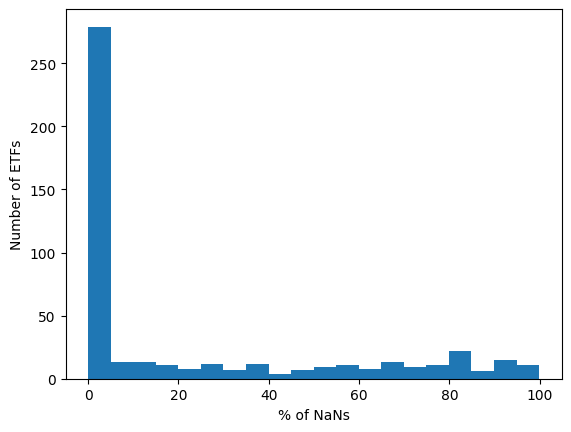

In [14]:
# Distribution of percentage of NaN values

plt.hist(nan_percentages, cumulative=False, bins=20)
plt.xlabel("% of NaNs")
plt.ylabel("Number of ETFs")
plt.show()

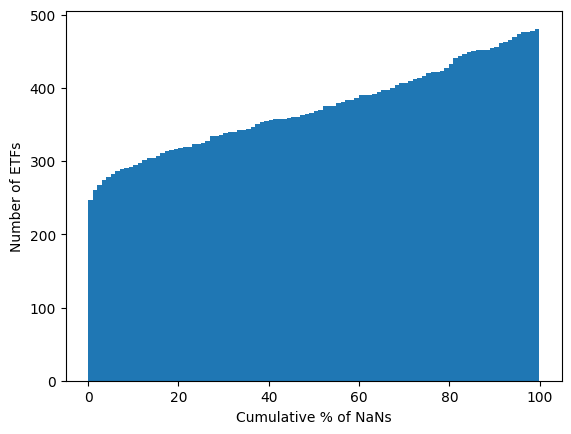

In [15]:
# Cumulative distribution of percentage of NaN values

plt.hist(nan_percentages, cumulative=True, bins=100)
plt.xlabel("Cumulative % of NaNs")
plt.ylabel("Number of ETFs")
plt.show()

### Dealing with NaN values

Missing data points will skew our model results. The dataset consists of weekdays and trading hours but does not account for bank holidays and the days where the markets are closed for transactions, therefore some missing data is to be expected for every ticker. Choosing 25% as a threshold for maximum number of missing data points per ticker leaves us with a healthy boundary both in terms of number of tickers remaining and number of existing data points per ticker.

We also do not want to consider ETFs that were inactive at the start of our training period or became inactive towards the end of the training period. This is for three reasons:
1. The trading period is not fully relevant for those ETFs, since they were not active throughout the whole duration
2. ETFs inactive at the start of the training period cannot be interpolated, therefore they are a blocker for our imputation method of choice
3. ETFs inactive at the end of the training period cannot be traded now or in the future, becoming a blocker for testing our trading strategy in Chapter 3.

To filter them out, we employ a rather primitive approach: Checking for missing values at the first and last timestamp of the series. This approach will surely eliminate some ETFs which were missing data on those specific timestamps for other reasons than being inactive, but for the sake of this experiment and the healthy number of ETFs remaining after the procedure, we stick to our approach.

Lastly, for remaining missing data points in the dataset, we use linear interpolation so that the data our model receives has no missing data.

In [16]:
# Drop series with more than 25% NaN values

valid_etfs = nan_percentages[nan_percentages == 0]
df = df[valid_etfs.index]

print(f"Number of valid ETFs: {len(valid_etfs)}")

Number of valid ETFs: 214


In [17]:
# Drop series if first or last value is NaN

valid_columns = df.columns[df.iloc[0].notna() & df.iloc[-1].notna()]
df = df[valid_columns]

print(f"Number of valid ETFs: {len(valid_columns)}")

Number of valid ETFs: 214


In [18]:
# Linear interpolation to impute NaN values

# df = df.apply(pd.to_numeric, errors='coerce')
# df.interpolate(method='linear', axis=0, inplace=True)

# print(df.head())

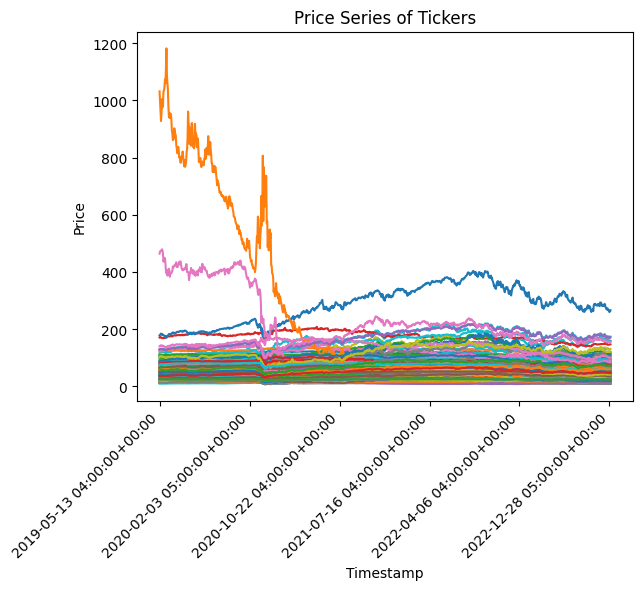

In [19]:
# Plot all remaining price series

for column in df.columns:
    plt.plot(df.index, df[column], label=column)

    # Add labels and legend
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Price Series of Tickers')
num_ticks = 5  # Specify the number of ticks you want to display
plt.xticks(df.index[::len(df.index)//num_ticks])
plt.xticks(rotation=45, ha='right')
plt.show()

### Why do we use returns instead of prices?

For the rest of our clustering approach, we will use daily returns instead of prices. Returns have multiple advantages over prices:

1. **Normalization:** Returns are often more normalized than prices themselves. Prices have different scales and nominal magnitudes, whereas returns are the relative change in prices with the same scale. Returns are more comparable, whereas absolute prices are arbitrary and dependent on outside factors such as enterprise value and outstanding shares.

2. **Stationarity & Homoskedasticity:** Returns tend to be more stationary compared to prices. They are usually homoskedastic in nature, implying that their statistical properties are independent of time and absolute prices. The volatility of returns are more stable over time whereas price changes are not.

3. **Relativity & Correlation**: Returns are relative to the price in point t-1. Absolute prices are independent of historical prices. This makes spotting correlations in prices more difficult whereas spotting correlations in returns relatively simpler.

In [20]:
# Compute returns

df_returns = df.pct_change().iloc[1:]
print(df_returns.iloc[:,:5].head())

                               AAXJ      ACWI      ACWX      AGZD       AIA
Timestamp                                                                  
2019-05-14 04:00:00+00:00  0.014752  0.009289  0.010643  0.001468  0.010587
2019-05-15 04:00:00+00:00  0.005785  0.004044  0.004388 -0.003978  0.004224
2019-05-16 04:00:00+00:00 -0.003392  0.007500  0.003058  0.001303 -0.001851
2019-05-17 04:00:00+00:00 -0.017611 -0.007582 -0.008929  0.001797 -0.019218
2019-05-20 04:00:00+00:00 -0.009340 -0.006112 -0.003735 -0.000054 -0.008422


In [21]:
# Save variables in a pickle file

with open('../../data/ch0_etfs.pkl', 'wb') as f:
    pickle.dump([df, df_returns], f)